# CH03-Dataset和DataLoader

我们希望数据集代码与模型训练的代码分离，以获得更好的可读性和模块化。

PyTorch提供了两个数据原语：`torch.utils.data.DataLoader`和`torch.utils.data.Dataset` ，让您使用预加载数据集，以及您自己的数据。

+ Dataset存储样本及其相应标签

+ DataLoader是包装在Dataset上的一个可迭代对象，以访问样本和标签。

PyTorch提供了许多数据集：

+ 图像数据集：https://pytorch.org/vision/stable/datasets.html 

+ 文本数据集：https://pytorch.org/text/stable/datasets.html

+ 音频数据集：https://pytorch.org/audio/stable/datasets.html

## 1 加载数据集

使用`torchversion.datasets`，下载数据集。

以下是如何从 TorchVision加载Fashion-MNIST数据集的示例。

>Fashion-MNIST 由 60,000 个训练样本和 10,000 个测试样本组成。每个样本包含一个 28×28 灰度图和来自 10 个类别之一的相关标签。

我们使用以下参数加载FashionMNIST 数据集：

+ root 是存储数据的路径，
 
+ train 指定训练或测试数据集，

+ download=True 如果数据不可用，则从 Internet 下载数据到文件夹root。

+ transform  特征和标签转换

In [1]:
import torch
from torchvision import datasets,transforms

import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=transforms.ToTensor()
)

## 2 可视化数据集

`training_data[index]`访问样本，使用`matplotlib`可视化样本。

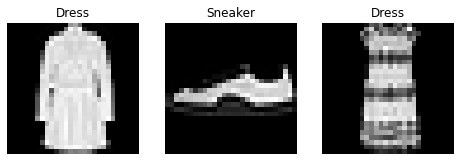

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 3 使用Dataloader

使用`torch.utils.data.DataLoader`加载数据。

在训练模型时，我们通常希望以“小批量”形式传递样本，DataLoader 正是这样一个迭代器。

train_dataloader和test_dataloader一次接受一个小批量的数据。

遍历DataLoader

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


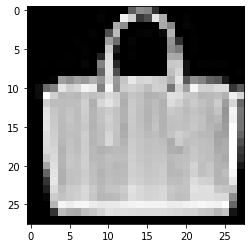

Label: 8


In [44]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 4 自定义Dataset

自定义的CustomDataset类继承自`
torch.utils.data.Dataset`类，所以必须实现以下三个函数：

+ `__init__`

+ `__len__`

+ `__getitem__`

示例：

生成img_dir和annotation_files：将FashionMNIST中的图像，存储在文件ch03_img中，标签单独存储在lable.csv文件中，label.csv内容如下：
```
001.jpg, 0
002.jpg, 0
...
999.jpg, 9
```
### 4.1 生成数据集：img_dir和lable.csv

In [18]:
import os
import pandas as pd

# 生成数据集
img_dir="data_ch03/img"
annotations_file="data_ch03/label.csv"
labels=[]
for i in range(1,101):
    img,label=training_data[i]
    image_name=str(i).zfill(3) + ".jpg"
    labels.append([image_name,label])
    plt.imsave(img_dir + "/" + image_name,img.squeeze())
# 保存为label.csv
df = pd.DataFrame(data=labels)
df.to_csv(annotations_file, encoding="utf-8-sig", mode="w", header=True, index=False)

# label=pd.read_csv("data_ch03/label.csv")
# label

### 4.2 自定义CustomDataset类

该类继承自`torch.utils.data.Dataset`, 定义该类需要实现3个函数.

In [21]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 4.3 加载数据

In [24]:
train_custom_data=CustomImageDataset(annotations_file,img_dir)

### 4.3 遍历数据

遍历数据，仍然使用的是`torch.utils.data.DataLoader`

Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64])
torch.Size([28, 28])


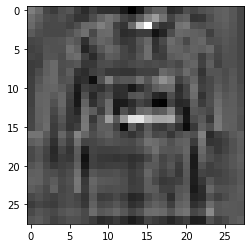

Label: 2


In [61]:
# from torch.utils.data import DataLoader
train_custom_dataloader = DataLoader(train_custom_data, batch_size=64, shuffle=True)
# test__custom_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_custom_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# 保存的图像，是3*28*28，只需要单通道：1*28*28
img = train_features[0].squeeze()[0,:,:]
label = train_labels[0]
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

更多关于`torch.utils.data`API: https://pytorch.org/docs/stable/data.html